#**Exploratory Data Analysis for Speech Emotion Recognition**

In this notebook, EDA on the Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS) dataset is carried out before building the SER model.

#**Import Necessary Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

In [2]:
from zipfile import ZipFile

In [3]:
import librosa
import librosa.display

In [4]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


#**Preparing List of Audio Files with Labels**

In RAVEDESS dataset, there are 7,356 files (total size: 24.8 GB). The database contains 24 professional actors (12 female, 12 male), vocalizing two lexically-matched statements in a neutral North American accent.

**File naming convention**

Each of the 7356 RAVDESS files has a unique filename. The filename consists of a 7-part numerical identifier (e.g., 02-01-06-01-02-01-12.mp4). These identifiers define the stimulus characteristics:

Filename identifiers

*  Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
*  Vocal channel (01 = speech, 02 = song).
*  Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
*  Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
*  Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
*  Repetition (01 = 1st repetition, 02 = 2nd repetition).
*  Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).


Filename example: 02-01-06-01-02-01-12.mp4

*  Video-only (02)
*  Speech (01)
*  Fearful (06)
*  Normal intensity (01)
*  Statement "dogs" (02)
*  1st Repetition (01)
*  12th Actor (12)
*  Female, as the actor ID number is even.

**NOTE**: For this project, we will use only 'audio-only' files.

In [5]:
# Path to dataset (zipfile)
dataset_path = '/content/drive/MyDrive/Capstone_Project/archive.zip'

# Directory to extract the contents
extracted_dir = '/content/archive'

# Create the directory if it doesn't exist
os.makedirs(extracted_dir, exist_ok=True)

# Unzip the folder
with ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)

# List all contents of the extracted folder
contents = os.listdir(extracted_dir)

In [6]:
# Filter directories starting with 'Actor_'
actor_directories = [d for d in contents if d.startswith('Actor_')]

# Create a list to store folder details
path_vec = []
label_vec = []

In [7]:
# Store the path of a file and its label to two lists
pos_label_in_filename = 2
for d in actor_directories:
    actor_dir = os.listdir(extracted_dir + '/' + d)
    for file in actor_dir:
        tmp = file.split('.')[0]
        tmp = tmp.split('-')
        label_vec.append(int(tmp[pos_label_in_filename]))
        path_vec.append(extracted_dir + '/' + d + '/' + file)

In [8]:
# Create a dataframe
df  = pd.DataFrame(path_vec, columns=['File_Path'])
df['Label'] = label_vec

In [9]:
df

File_Path  Label
0     /content/archive/Actor_13/03-01-07-02-01-01-13...      7
1     /content/archive/Actor_13/03-01-08-01-02-02-13...      8
2     /content/archive/Actor_13/03-01-05-02-01-01-13...      5
3     /content/archive/Actor_13/03-01-04-01-02-01-13...      4
4     /content/archive/Actor_13/03-01-05-02-01-02-13...      5
...                                                 ...    ...
1435  /content/archive/Actor_16/03-01-06-02-01-02-16...      6
1436  /content/archive/Actor_16/03-01-03-01-01-01-16...      3
1437  /content/archive/Actor_16/03-01-08-02-01-02-16...      8
1438  /content/archive/Actor_16/03-01-05-02-01-01-16...      5
1439  /content/archive/Actor_16/03-01-02-02-02-01-16...      2

[1440 rows x 2 columns]

#**Exploratory Data Analysis**

##**Check Balance of Target Classes**

In [10]:
tmp_df = df.copy()
# Modifying labels from integers to actual emotions.
tmp_df.Label.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fearful', 7:'disgust', 8:'surprised'}, inplace=True)
tmp_df.head()

File_Path      Label
0  /content/archive/Actor_13/03-01-07-02-01-01-13...    disgust
1  /content/archive/Actor_13/03-01-08-01-02-02-13...  surprised
2  /content/archive/Actor_13/03-01-05-02-01-01-13...      angry
3  /content/archive/Actor_13/03-01-04-01-02-01-13...        sad
4  /content/archive/Actor_13/03-01-05-02-01-02-13...      angry

In [11]:
label_counts  = tmp_df['Label'].value_counts()

In [12]:
label_counts

disgust      192
surprised    192
angry        192
sad          192
calm         192
fearful      192
happy        192
neutral       96
Name: Label, dtype: int64

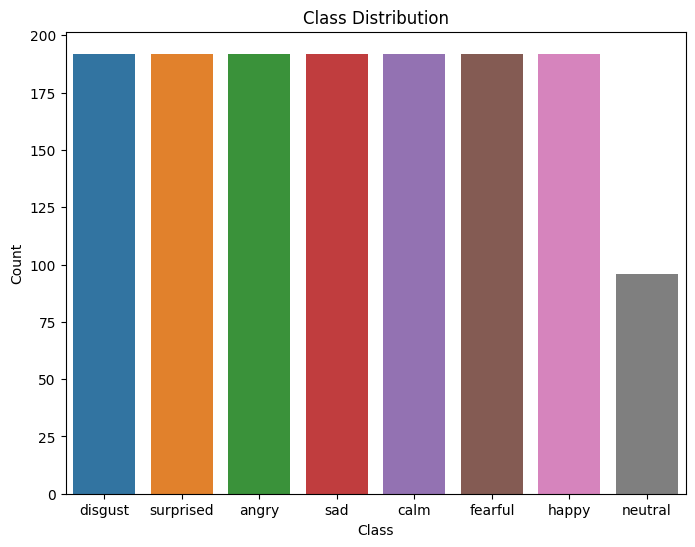

In [13]:
class_counts = tmp_df['Label'].value_counts()

# Plot the class distribution using seaborn
plt.figure(figsize=(8, 6))
sns.countplot(x='Label', data=tmp_df, order=class_counts.index)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

**Inference**: Apart from 'neutral' emotion that contains 96 files, the rest of the emotions consists of 192 files each.

##**Plotting Audio Data - Waveplots and Mel Spectrograms**
In this section, we randomly choose 'num_plots' of audio files from each emotion. Then, waveplot and mel spectrogram of these files are plotted.

A **waveplot, or waveform plot**, is a graphical representation of a sound wave in the time domain. It shows how the amplitude of the sound signal varies over time.

A **Mel spectrogram** is a visual representation of the spectrum of a sound signal, showing how the frequency content of the signal changes over time. It is derived from the spectrogram but uses the Mel scale, which is a perceptual scale of pitches that approximates the human ear's response to different frequencies.

In [14]:
SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 30

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

<ipython-input-16-9d2ad2230fe1>:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


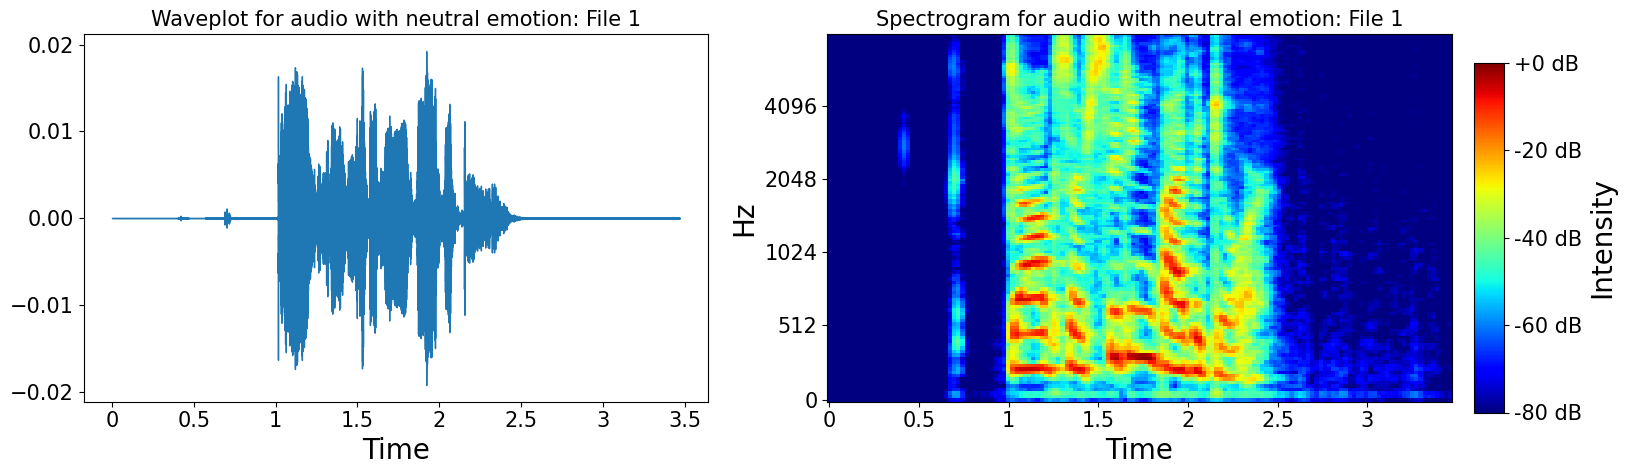

<ipython-input-16-9d2ad2230fe1>:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


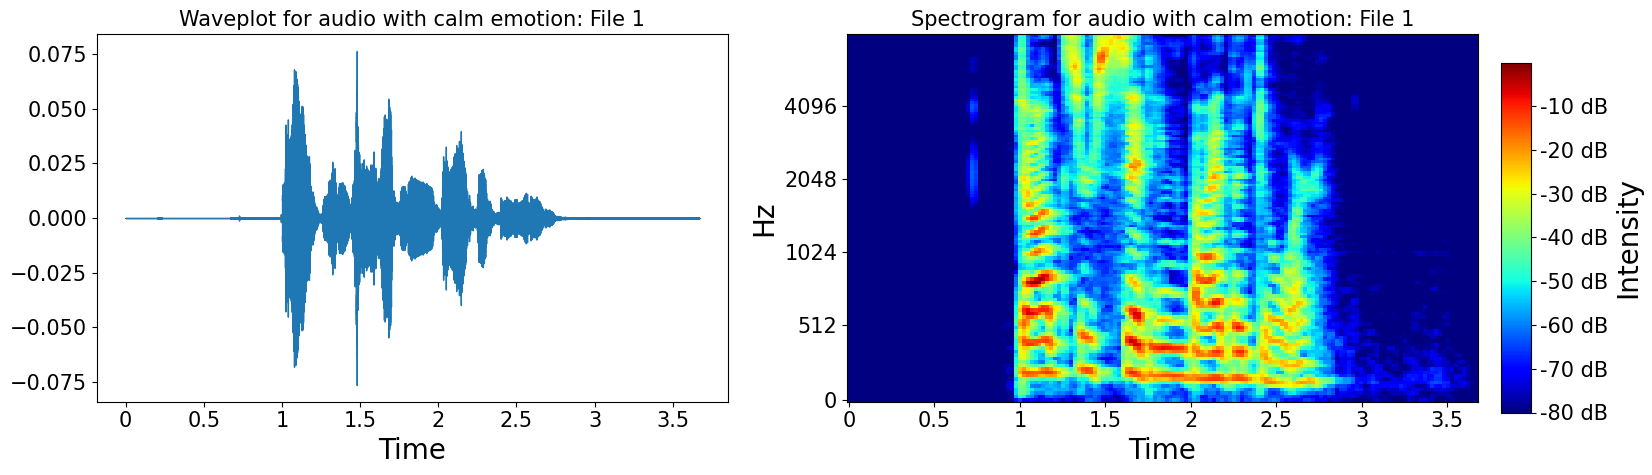

<ipython-input-16-9d2ad2230fe1>:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


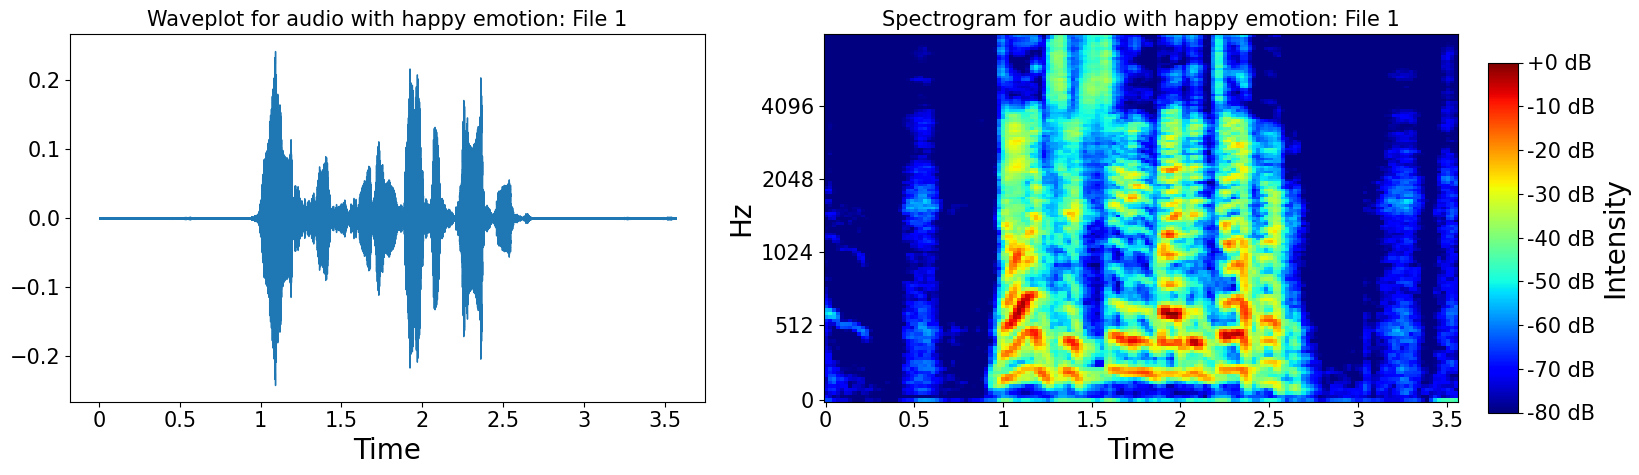

<ipython-input-16-9d2ad2230fe1>:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


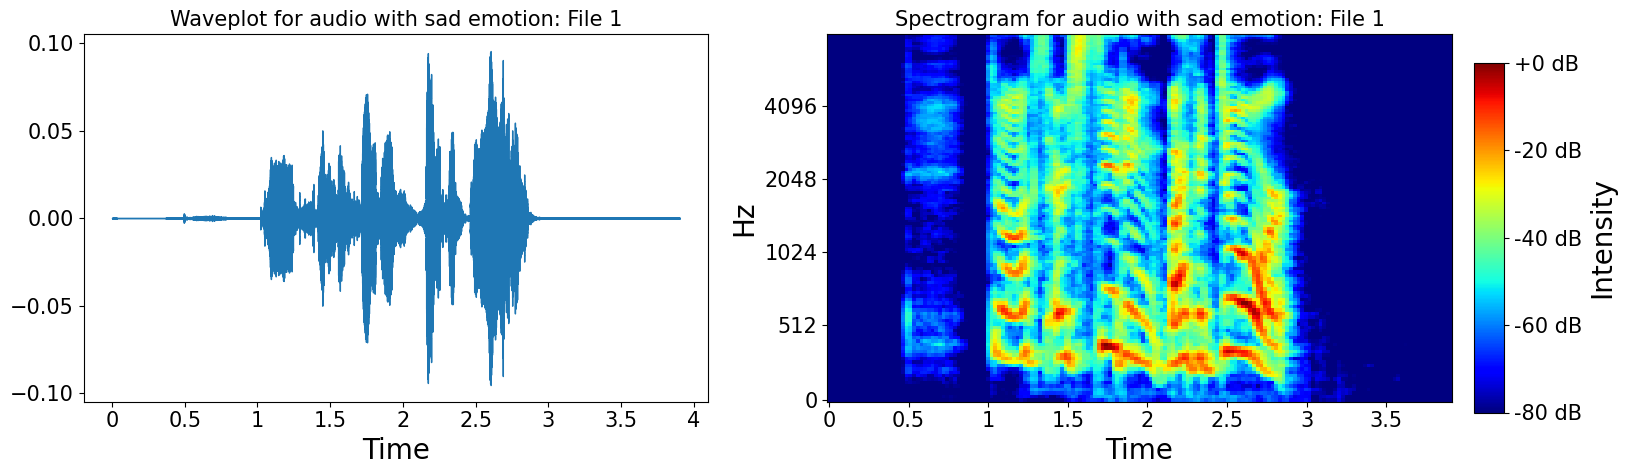

<ipython-input-16-9d2ad2230fe1>:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


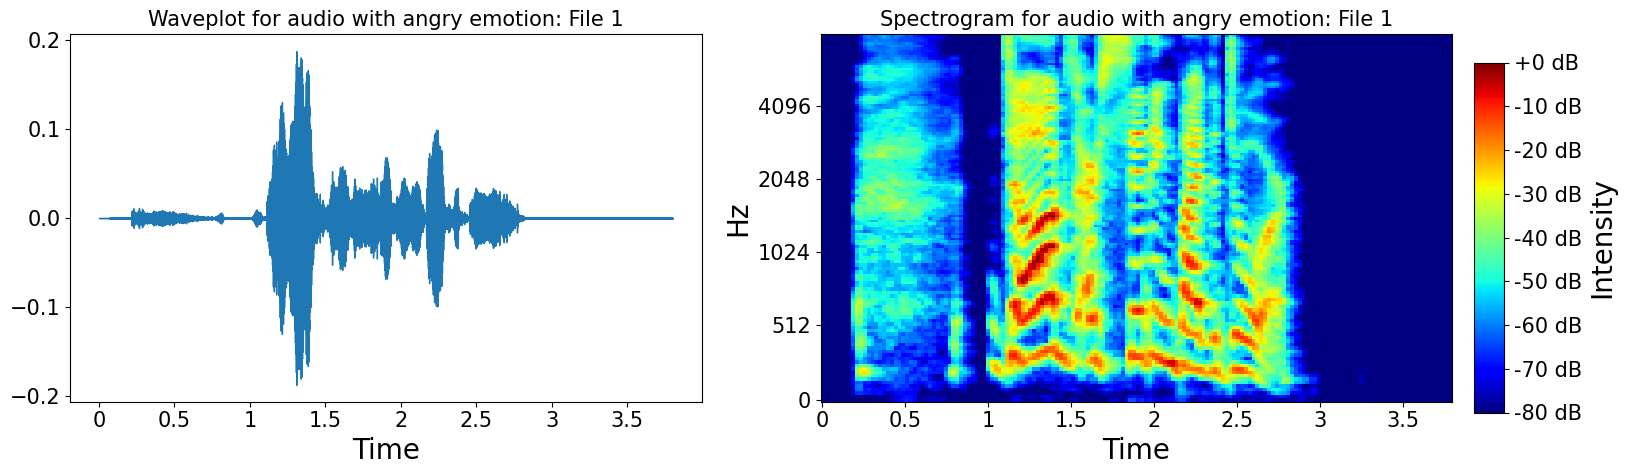

<ipython-input-16-9d2ad2230fe1>:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


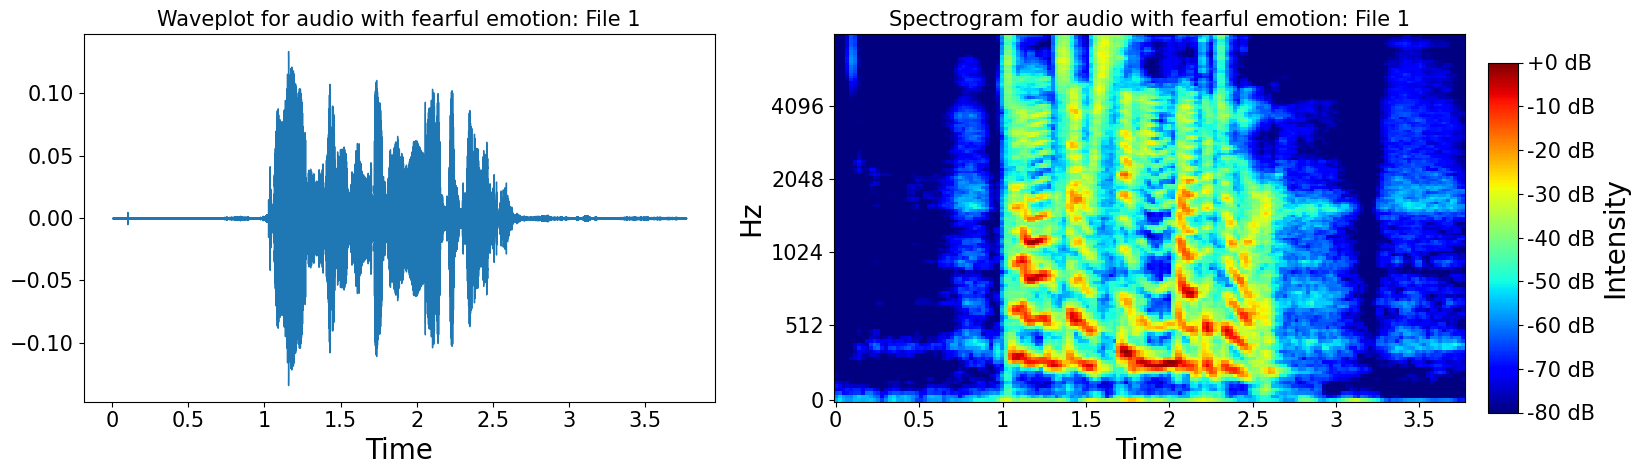

<ipython-input-16-9d2ad2230fe1>:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


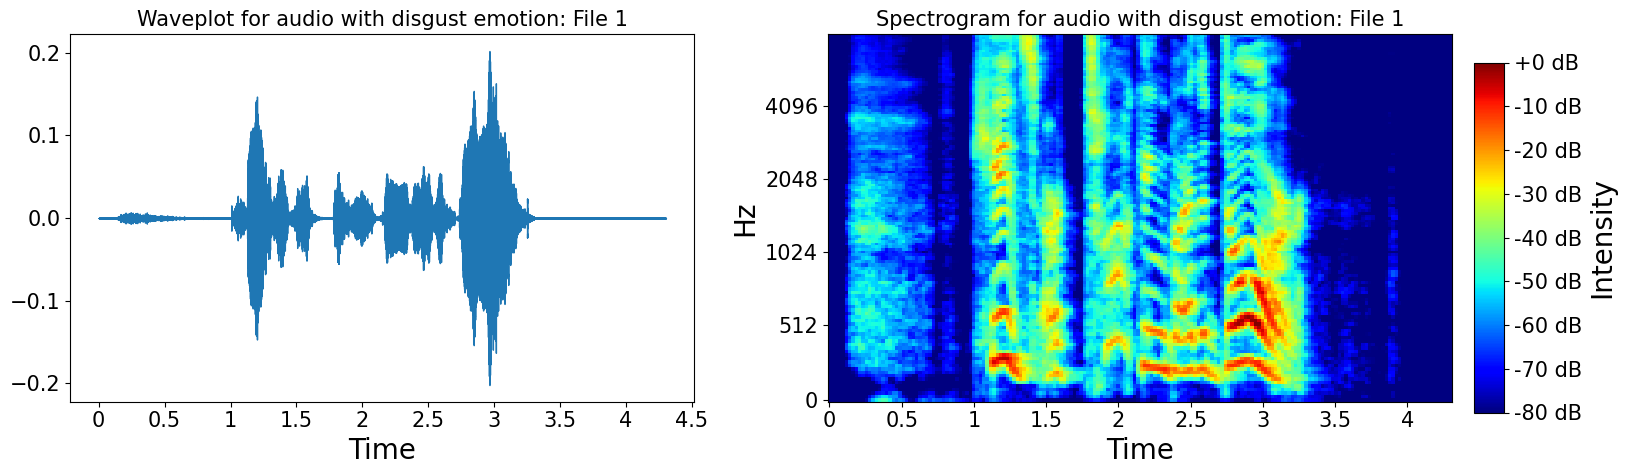

<ipython-input-16-9d2ad2230fe1>:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


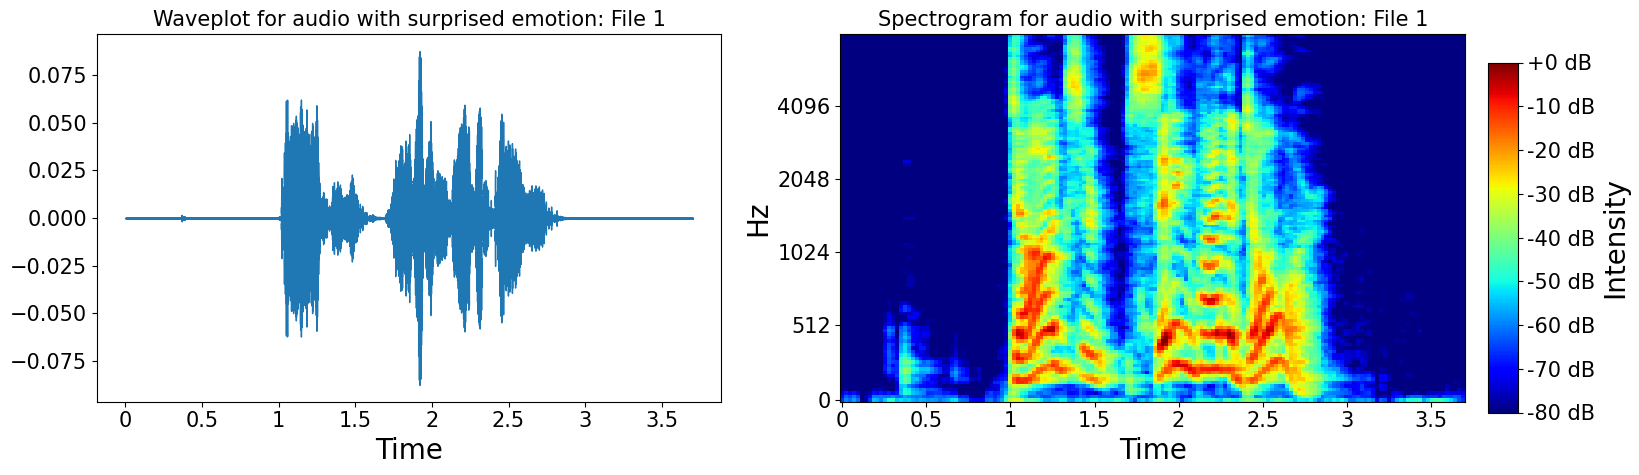

In [16]:
emotions_list = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
num_plots     = 1
for e in emotions_list:
  # Randomly choose row indices where 'Label' column is of the emotion e
  e_indices = tmp_df[tmp_df['Label'] == e].index

  # Randomly choose, for example, 3 indices
  random_fear_indices = np.random.choice(e_indices, size=num_plots, replace=False)

  # Display the plots of audio files at the randomly chosen indices
  random_e_data = df.loc[random_fear_indices]

  for iter in range(num_plots):
    filepath  = random_e_data.iloc[iter].File_Path
    data, sampling_rate = librosa.load(filepath)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    # Plot the waveplot
    ax1.set(title = 'Waveplot for audio with {} emotion: File {}'.format(e, iter+1))
    librosa.display.waveshow(data, sr=sampling_rate, ax=ax1)
    # Plot the spectrogram (frequency-domain representation)
    #D = librosa.amplitude_to_db(np.abs(librosa.stft(data)), ref=np.max)
    S = librosa.feature.melspectrogram(y=data, sr=sampling_rate, n_mels=128,
                                    fmax=8000)
    D = librosa.power_to_db(S, ref=np.max)
    img = librosa.display.specshow(D, sr=sampling_rate, x_axis='time', y_axis='mel', fmax=8000, cmap='jet', ax=ax2)
    #img = librosa.display.specshow(D, sr=sampling_rate, x_axis='time', y_axis='log', cmap='jet', ax=ax2)
    ax2.set(title='Spectrogram for audio with {} emotion: File {}'.format(e, iter+1))
    # Create a colorbar axis for the spectrogram
    cbar_ax = fig.add_axes([1.0, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    fig.colorbar(img, cax=cbar_ax, format='%+2.0f dB', label='Intensity')

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

##**Spectral Centroid**
It represents the "center of gravity" of a sound's frequency distribution. When the spectral centroid is towards the higher end of the frequency range, the sound is likely to be perceived as brighter. Conversely, a lower spectral centroid is associated with a darker or less bright sound.

**NOTE:** Brightness in the context of sound perception is a qualitative attribute related to the distribution of energy across the frequency spectrum, with brighter sounds having a higher concentration of energy in the higher frequencies.

Let us plot the spectral centroid for various emotions and see if there are any patterns.

<ipython-input-21-68a92377aa19>:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


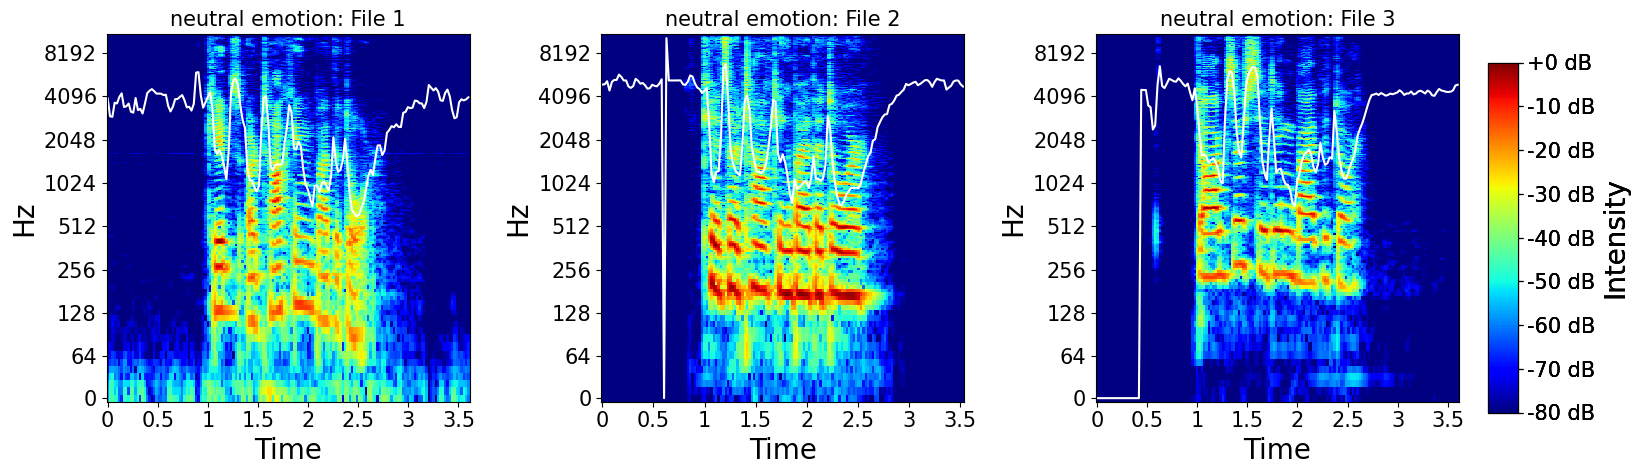

<ipython-input-21-68a92377aa19>:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


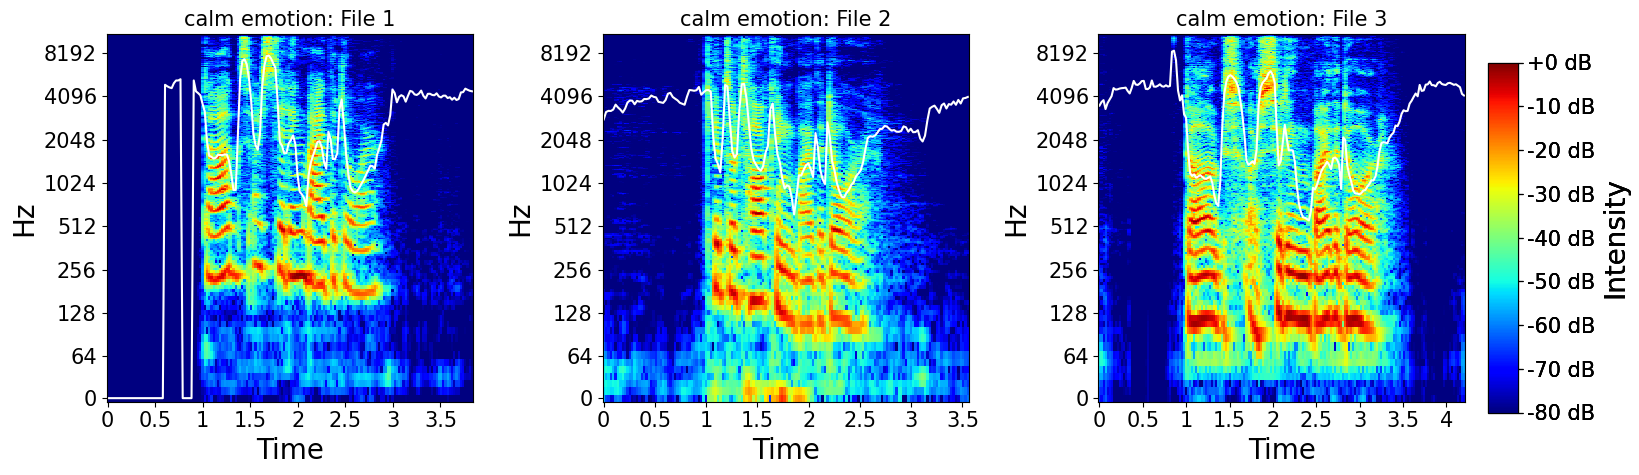

<ipython-input-21-68a92377aa19>:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


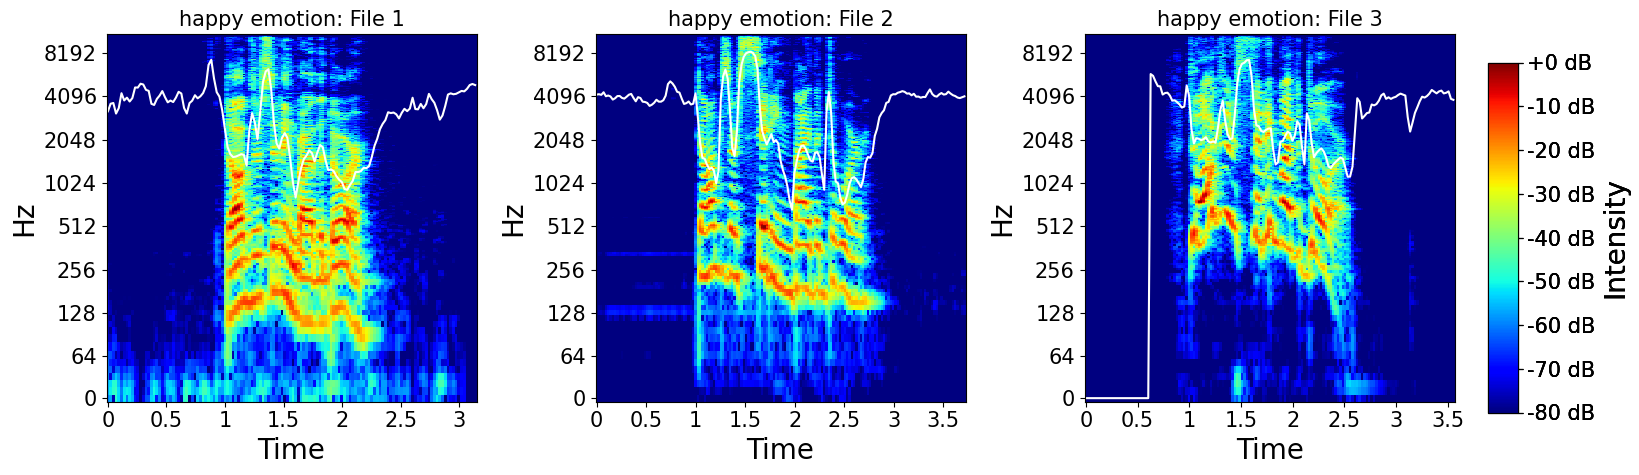

<ipython-input-21-68a92377aa19>:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


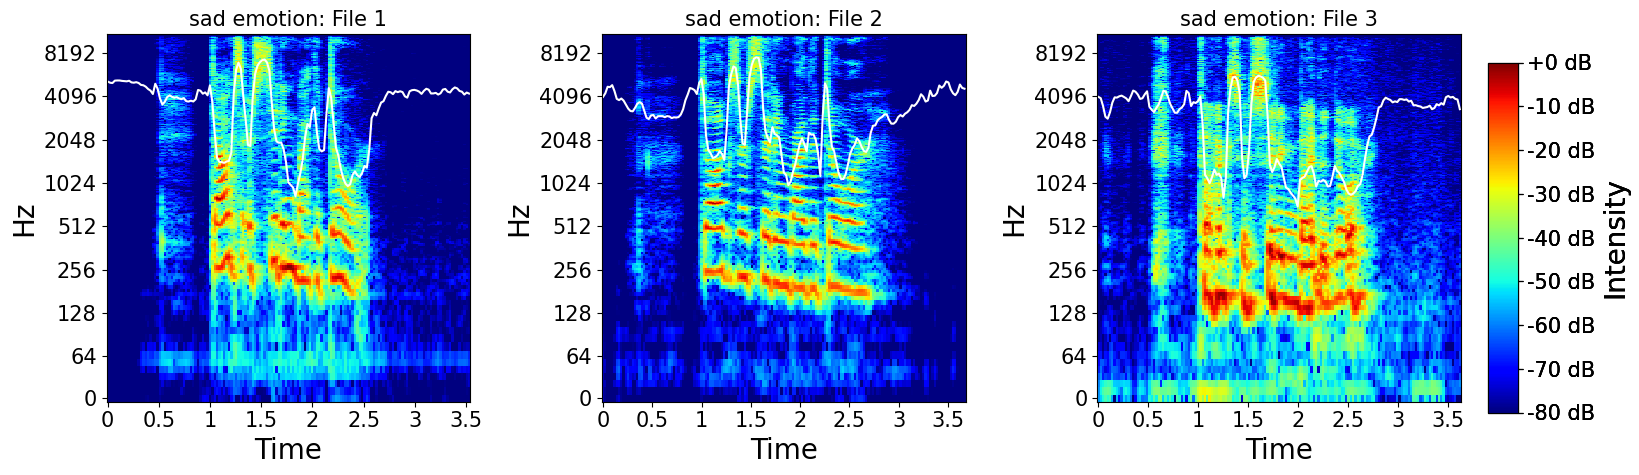

<ipython-input-21-68a92377aa19>:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


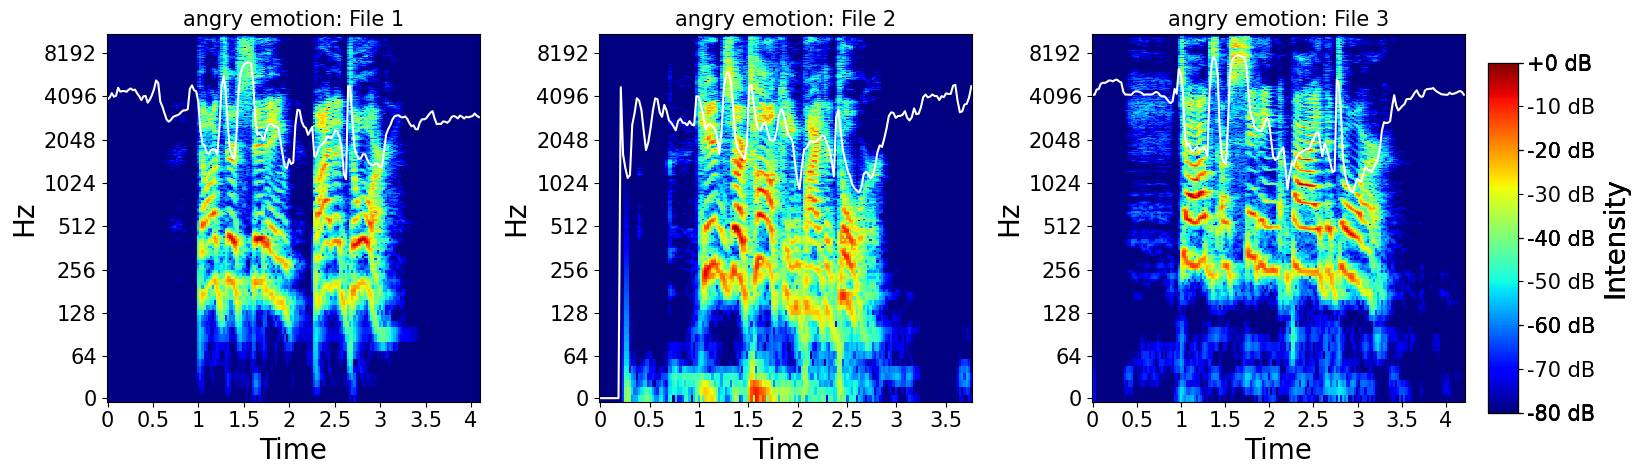

<ipython-input-21-68a92377aa19>:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


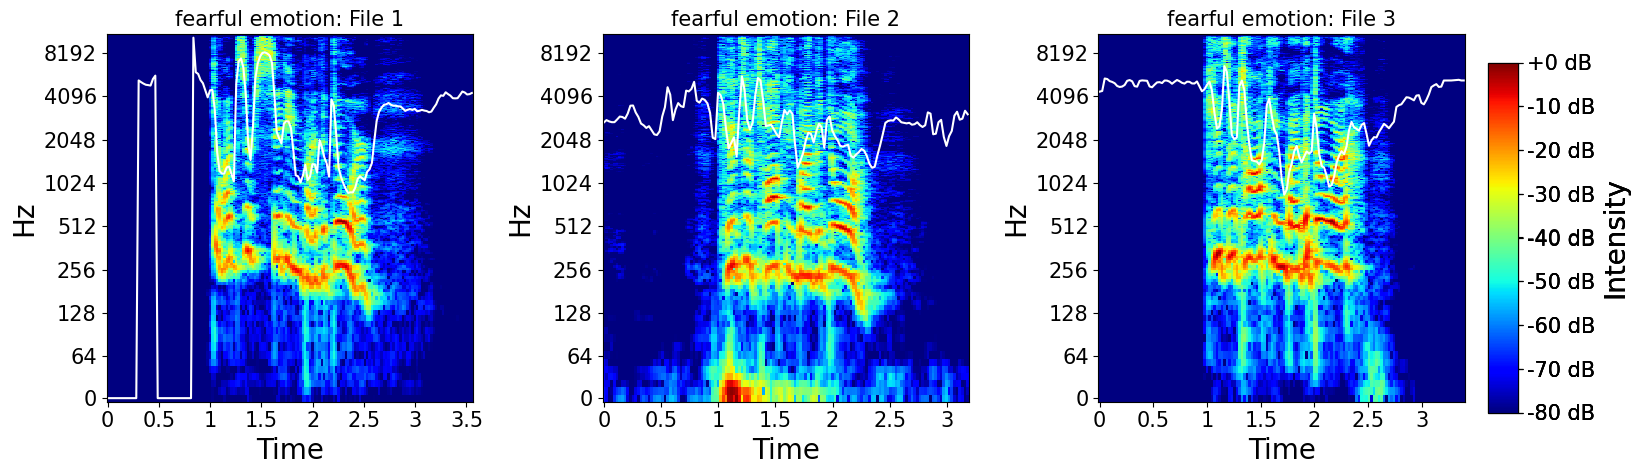

<ipython-input-21-68a92377aa19>:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


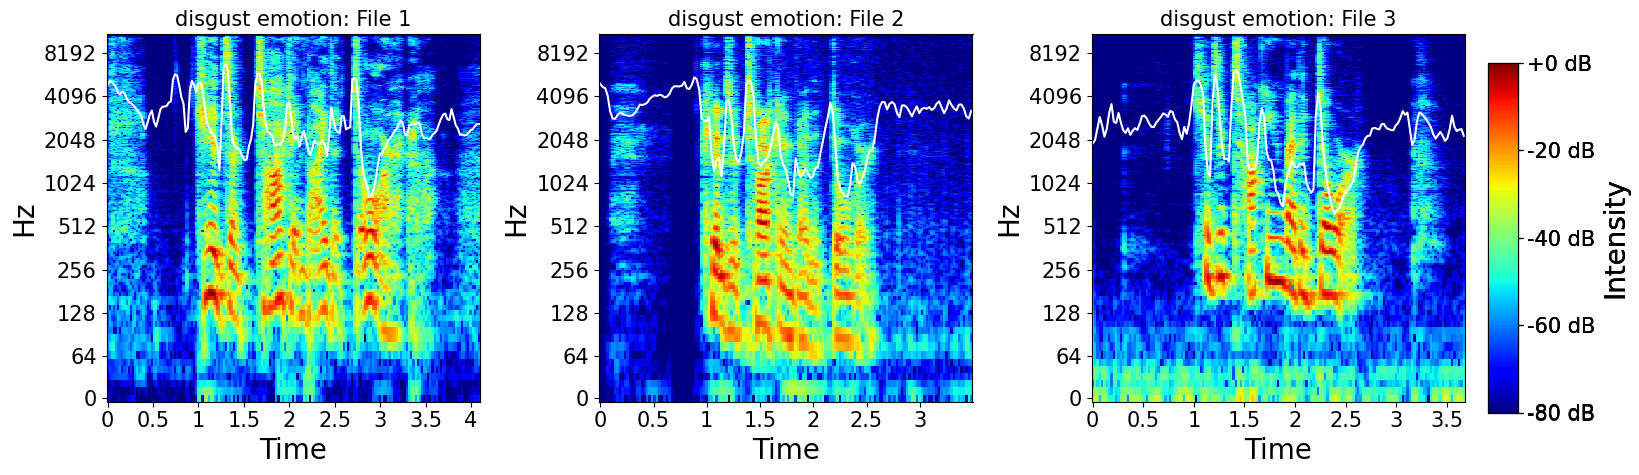

<ipython-input-21-68a92377aa19>:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


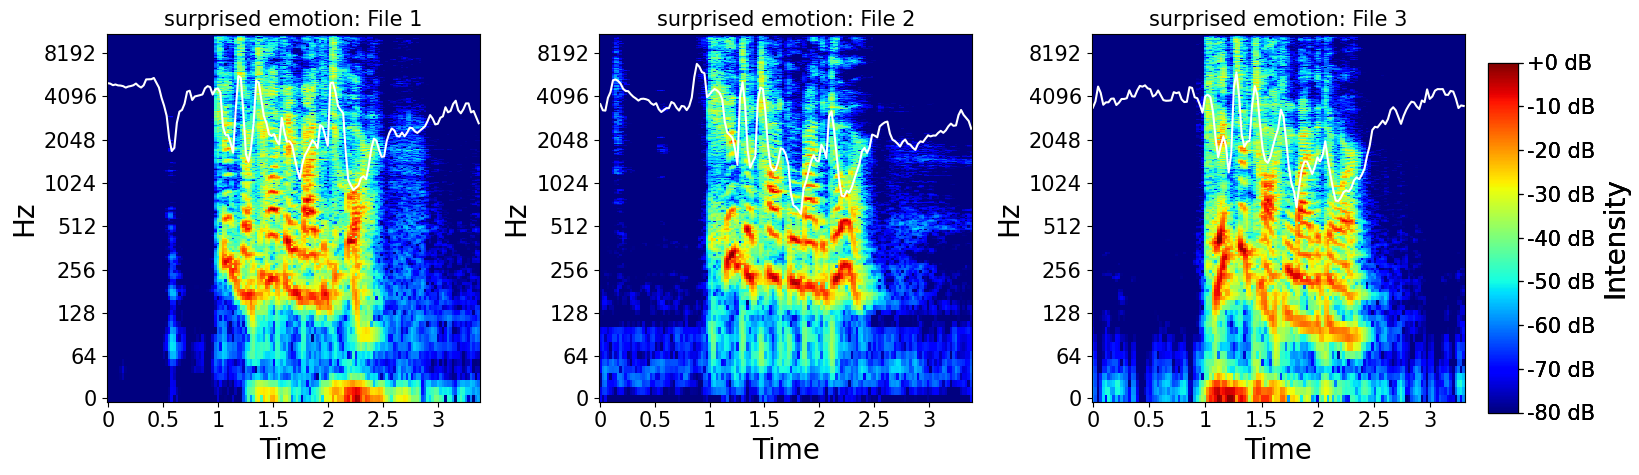

In [21]:
emotions_list = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
num_plots     = 3
for e in emotions_list:
  # Randomly choose row indices where 'Label' column is of the emotion e
  e_indices = tmp_df[tmp_df['Label'] == e].index

  # Randomly choose, for example, 3 indices
  random_indices = np.random.choice(e_indices, size=num_plots, replace=False)

  # Display the plots of audio files at the randomly chosen indices
  random_e_data = df.loc[random_indices]

  fig, ax = plt.subplots(1, 3, figsize=(15, 5))
  for iter in range(num_plots):
    filepath  = random_e_data.iloc[iter].File_Path
    data, sampling_rate = librosa.load(filepath)
    # Spectral centroid
    cent = librosa.feature.spectral_centroid(y=data, sr=sampling_rate)

    # Plot the spectrogram (frequency-domain representation) and the spectral centroid
    times = librosa.times_like(cent)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(data)), ref=np.max)
    img = librosa.display.specshow(D, sr=sampling_rate, x_axis='time', y_axis='log', cmap='jet', ax=ax[iter])
    ax[iter].set(title='{} emotion: File {}'.format(e, iter+1))
    ax[iter].plot(times, cent.T, label='Spectral centroid', color='w')

    # Create a colorbar axis for the spectrogram
    cbar_ax = fig.add_axes([1.0, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    fig.colorbar(img, cax=cbar_ax, format='%+2.0f dB', label='Intensity')

  # Adjust layout for better spacing
  plt.tight_layout()
  plt.show()

**Inference**: In the above plots, the white coloured curve over the spectrogram indicates the spectral centroid. From the plots for various emotions, no specific trend of spectral centroid with emotion could be concluded by visual inspection.

##**Pitch**
It corresponds to the perceived frequency of the sound wave. It is the human sensation of the highness or lowness of a sound.

Let us plot the pitch for various emotions and see if there are any patterns.

/usr/local/lib/python3.10/dist-packages/librosa/core/convert.py:1095: RuntimeWarning: divide by zero encountered in log2
  midi: np.ndarray = 12 * (np.log2(np.asanyarray(frequencies)) - np.log2(440.0)) + 69
<ipython-input-23-e901727f19bd>:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


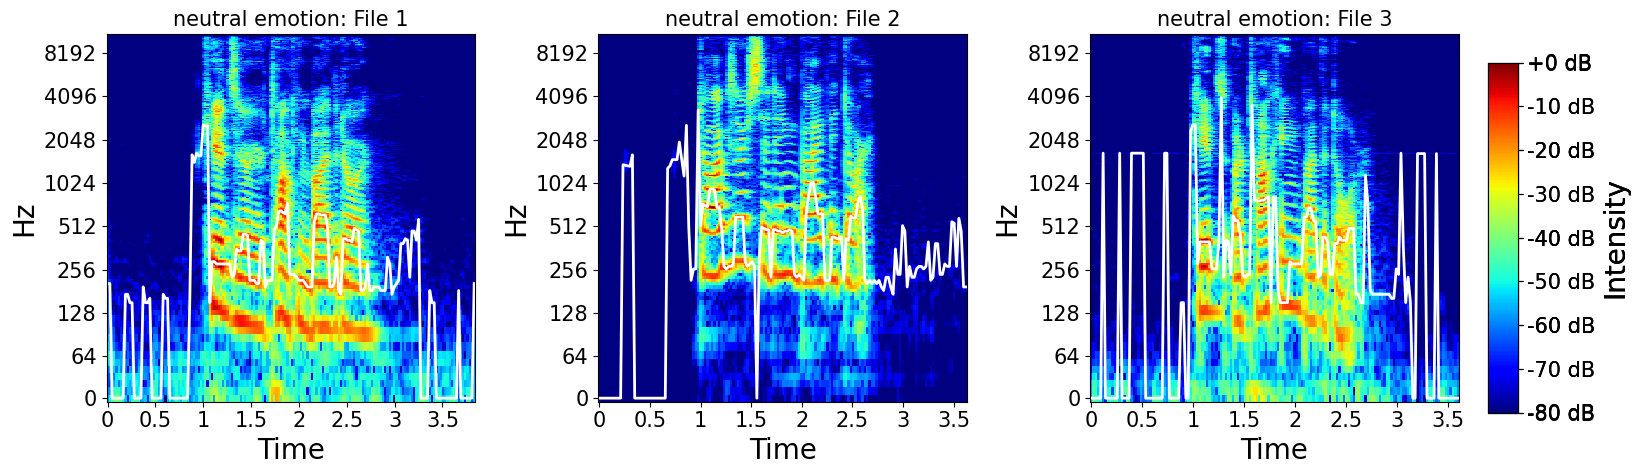

/usr/local/lib/python3.10/dist-packages/librosa/core/convert.py:1095: RuntimeWarning: divide by zero encountered in log2
  midi: np.ndarray = 12 * (np.log2(np.asanyarray(frequencies)) - np.log2(440.0)) + 69
<ipython-input-23-e901727f19bd>:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


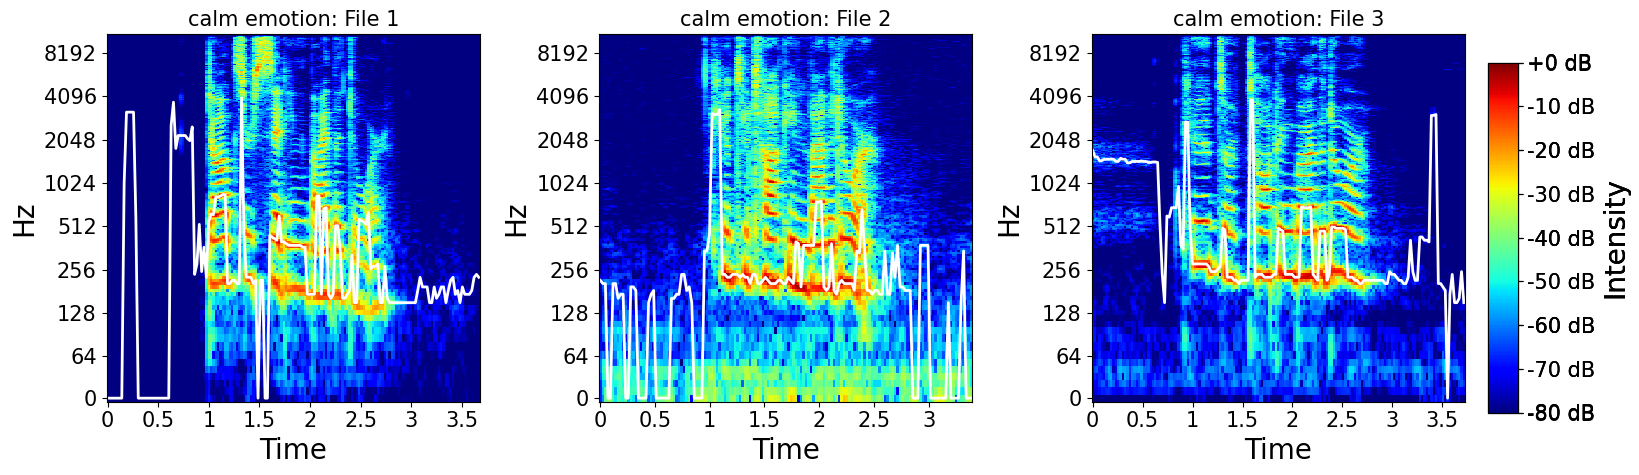

/usr/local/lib/python3.10/dist-packages/librosa/core/convert.py:1095: RuntimeWarning: divide by zero encountered in log2
  midi: np.ndarray = 12 * (np.log2(np.asanyarray(frequencies)) - np.log2(440.0)) + 69
<ipython-input-23-e901727f19bd>:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


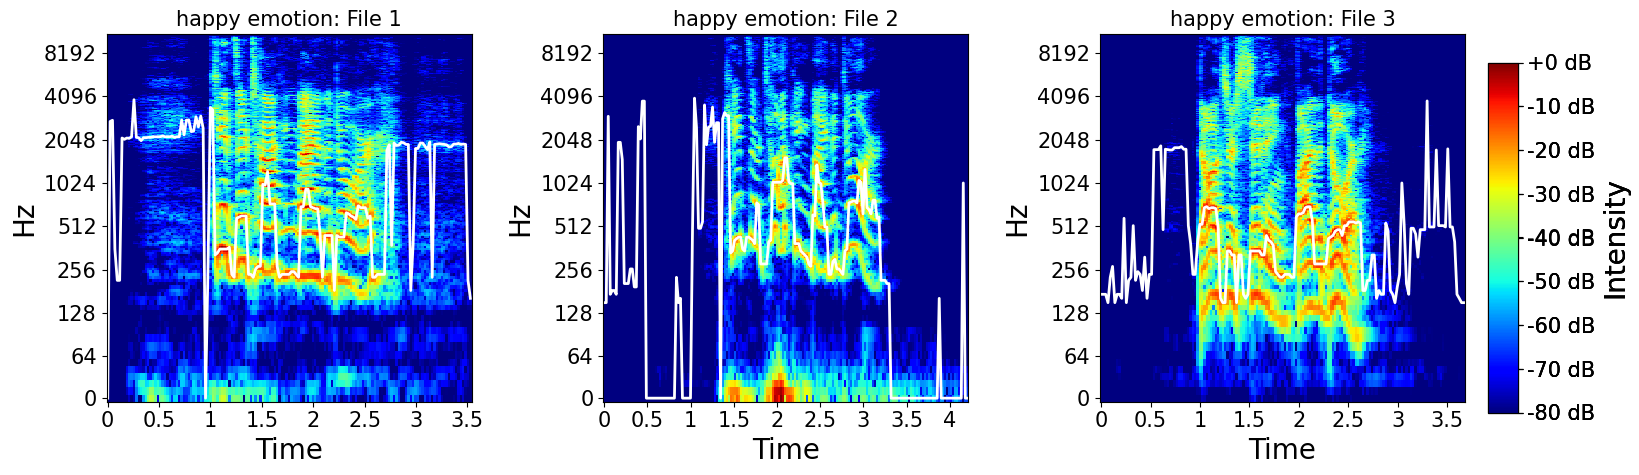

/usr/local/lib/python3.10/dist-packages/librosa/core/convert.py:1095: RuntimeWarning: divide by zero encountered in log2
  midi: np.ndarray = 12 * (np.log2(np.asanyarray(frequencies)) - np.log2(440.0)) + 69
<ipython-input-23-e901727f19bd>:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


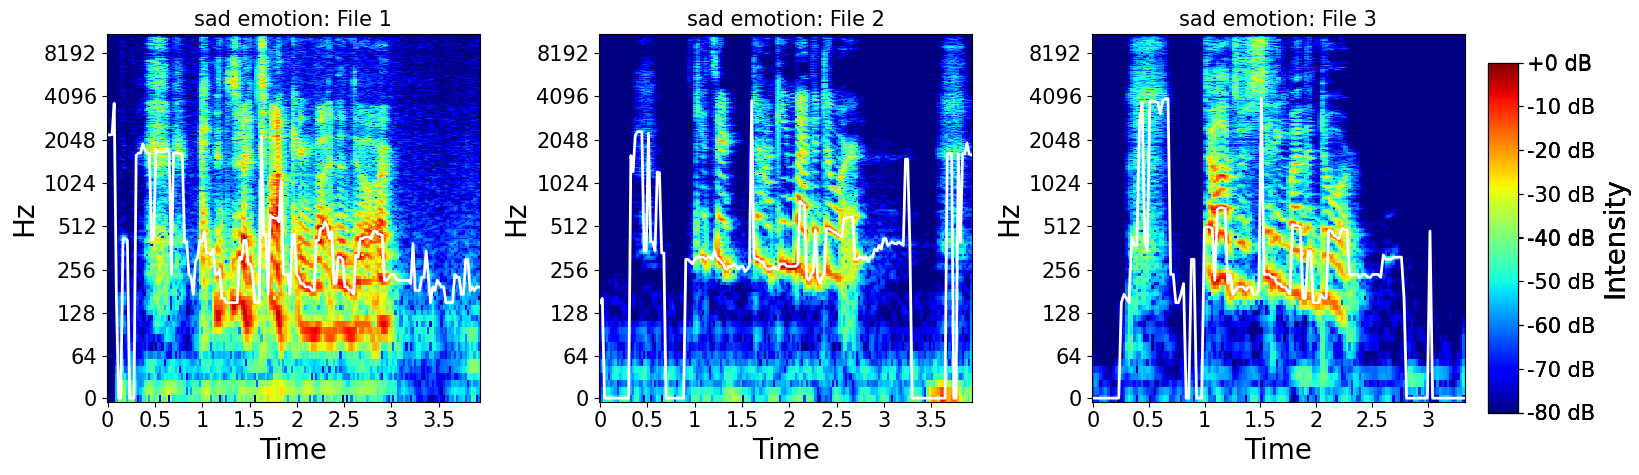

/usr/local/lib/python3.10/dist-packages/librosa/core/convert.py:1095: RuntimeWarning: divide by zero encountered in log2
  midi: np.ndarray = 12 * (np.log2(np.asanyarray(frequencies)) - np.log2(440.0)) + 69
<ipython-input-23-e901727f19bd>:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


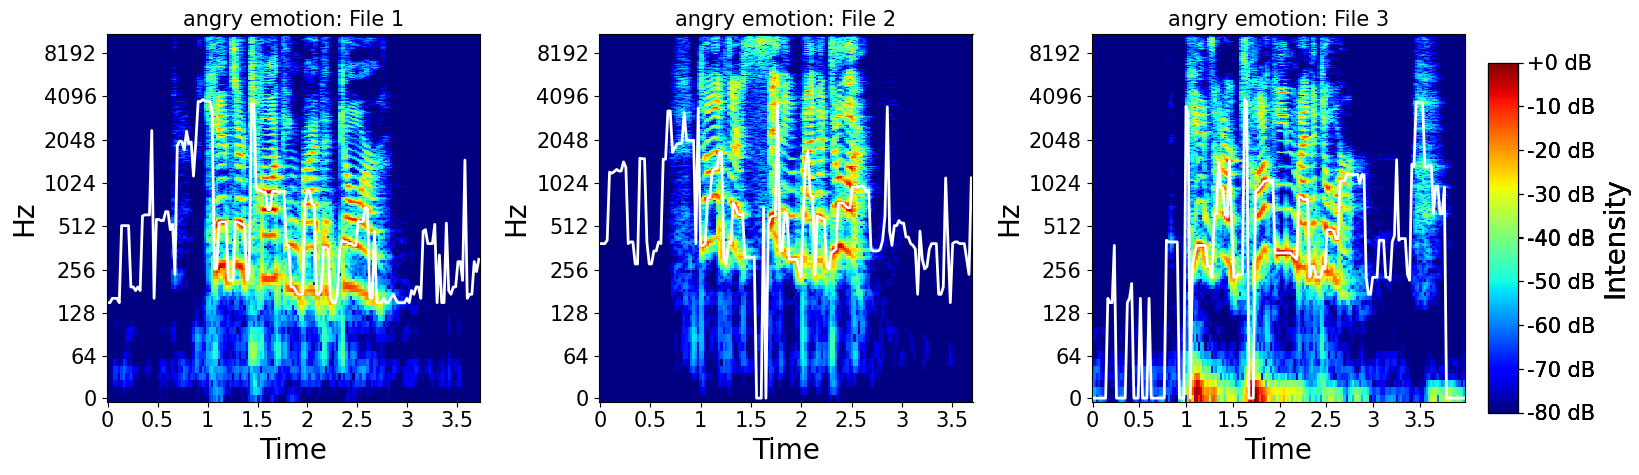

/usr/local/lib/python3.10/dist-packages/librosa/core/convert.py:1095: RuntimeWarning: divide by zero encountered in log2
  midi: np.ndarray = 12 * (np.log2(np.asanyarray(frequencies)) - np.log2(440.0)) + 69
<ipython-input-23-e901727f19bd>:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


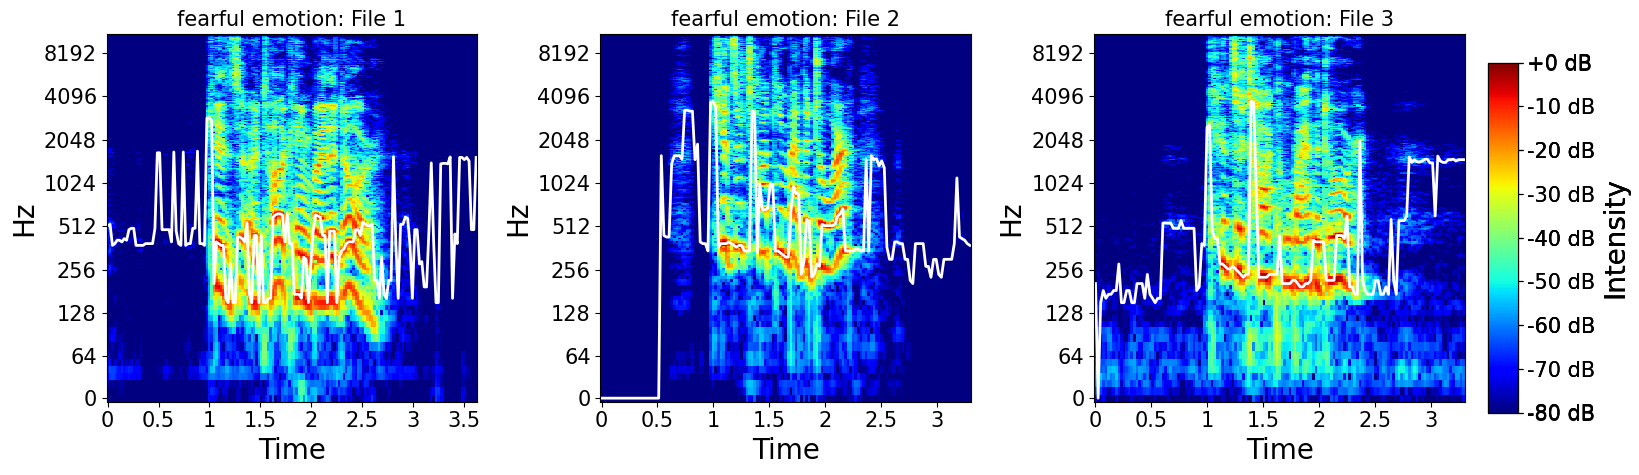

/usr/local/lib/python3.10/dist-packages/librosa/core/convert.py:1095: RuntimeWarning: divide by zero encountered in log2
  midi: np.ndarray = 12 * (np.log2(np.asanyarray(frequencies)) - np.log2(440.0)) + 69
<ipython-input-23-e901727f19bd>:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


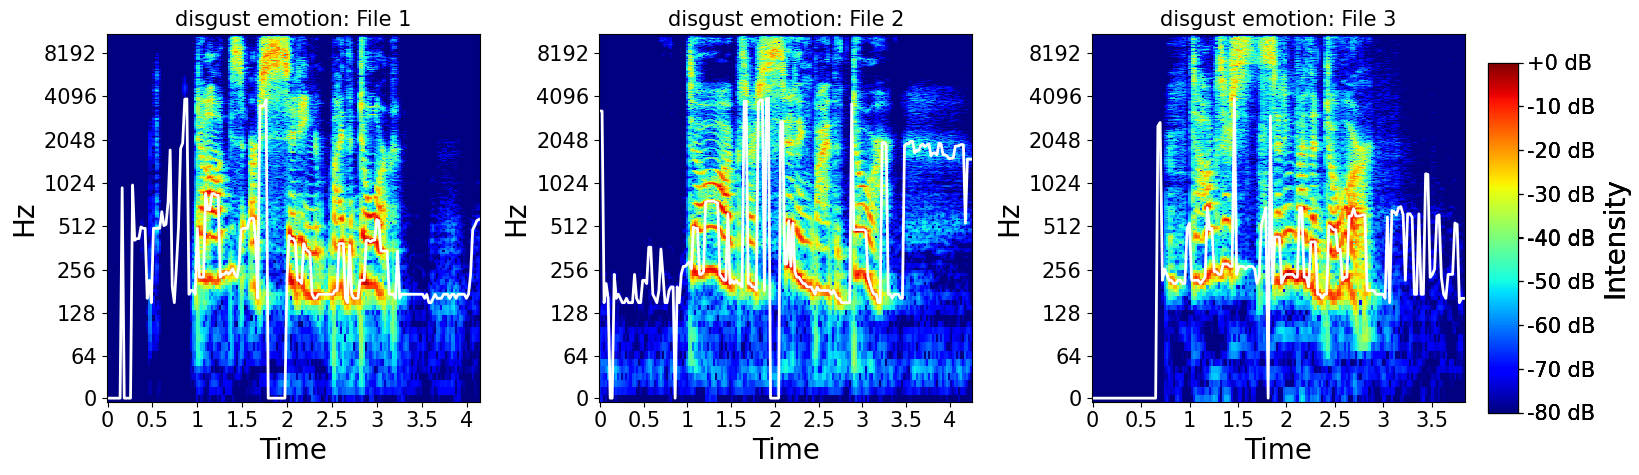

/usr/local/lib/python3.10/dist-packages/librosa/core/convert.py:1095: RuntimeWarning: divide by zero encountered in log2
  midi: np.ndarray = 12 * (np.log2(np.asanyarray(frequencies)) - np.log2(440.0)) + 69
<ipython-input-23-e901727f19bd>:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


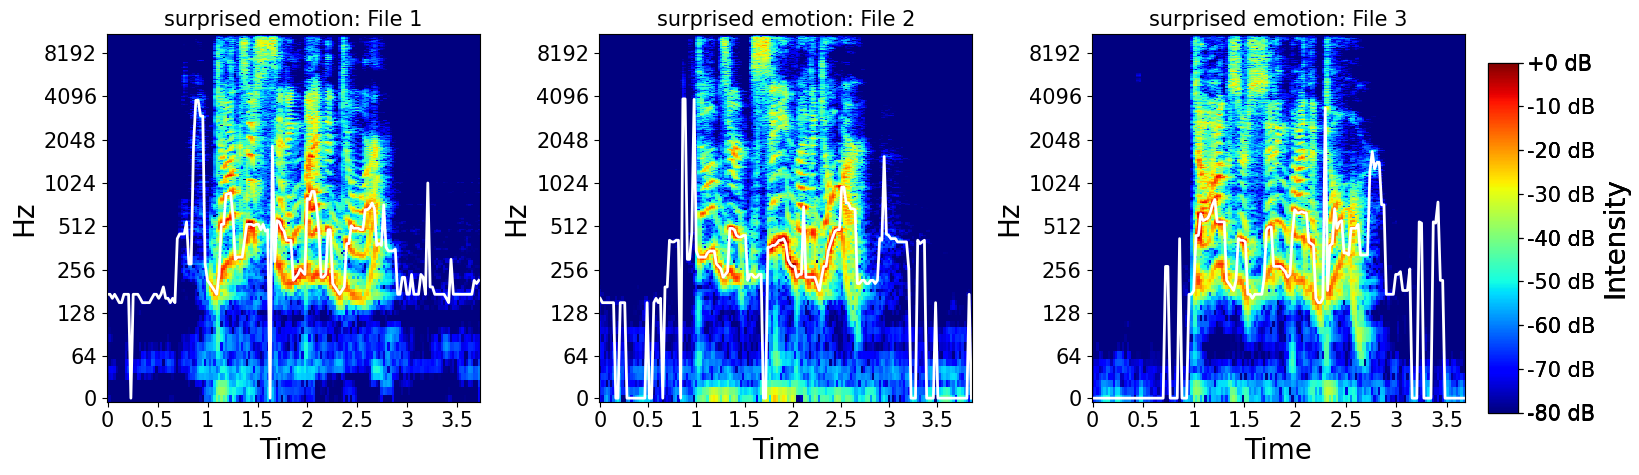

In [23]:
emotions_list = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
num_plots     = 3
for e in emotions_list:
  # Randomly choose row indices where 'Label' column is of the emotion e
  e_indices = tmp_df[tmp_df['Label'] == e].index

  # Randomly choose, for example, 3 indices
  random_indices = np.random.choice(e_indices, size=num_plots, replace=False)

  # Display the plots of audio files at the randomly chosen indices
  random_e_data = df.loc[random_indices]

  fig, ax = plt.subplots(1, 3, figsize=(15, 5))
  for iter in range(num_plots):
    filepath  = random_e_data.iloc[iter].File_Path
    data, sampling_rate = librosa.load(filepath)

    # Calculate pitch
    pitch, magnitudes = librosa.core.pitch.piptrack(y=data, sr=sampling_rate)
    # Get the index of the maximum magnitude for each frame
    idx_max = magnitudes.argmax(axis=0)
    # Convert the index to frequencies
    frequencies = librosa.core.midi_to_hz(librosa.core.hz_to_midi(librosa.core.fft_frequencies(sr=sampling_rate)))[idx_max]

    # Plot the spectrogram (frequency-domain representation) and the pitch
    times = librosa.times_like(pitch)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(data)), ref=np.max)
    img = librosa.display.specshow(D, sr=sampling_rate, x_axis='time', y_axis='log', cmap='jet', ax=ax[iter])
    ax[iter].set(title='{} emotion: File {}'.format(e, iter+1))
    ax[iter].plot(times, frequencies, label='Estimated pitch', color='w', linewidth=2)

    # Create a colorbar axis for the spectrogram
    cbar_ax = fig.add_axes([1.0, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    fig.colorbar(img, cax=cbar_ax, format='%+2.0f dB', label='Intensity')

  # Adjust layout for better spacing
  plt.tight_layout()
  plt.show()

**Inference**: In the above plots, the white coloured curve over the spectrogram indicates the pitch variation with time. From the plots for various emotions, no specific trend of pitch with emotion could be concluded by visual inspection.

##**RMS Energy**
The RMS of energy is a measure that quantifies the average strength or amplitude of a signal.

Let us plot the RMS energy for various emotions and see if there are any patterns.

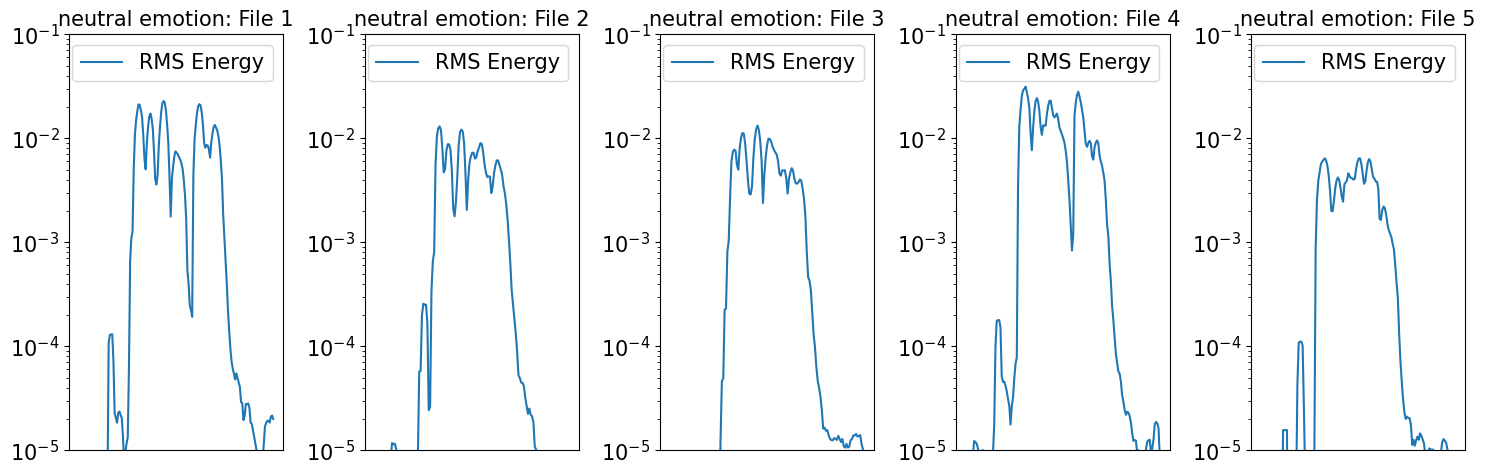

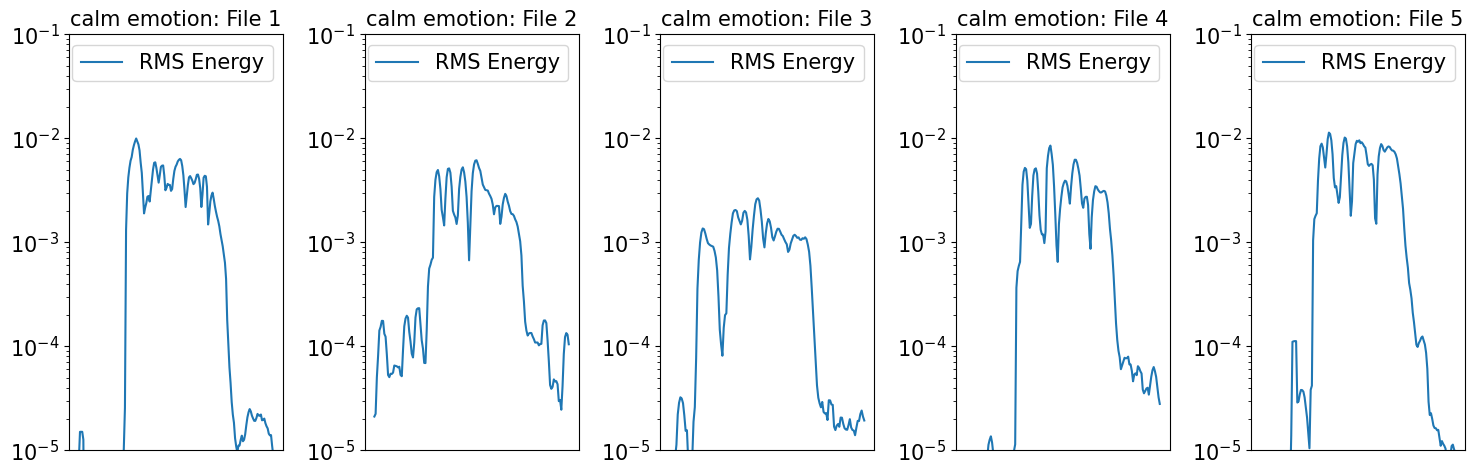

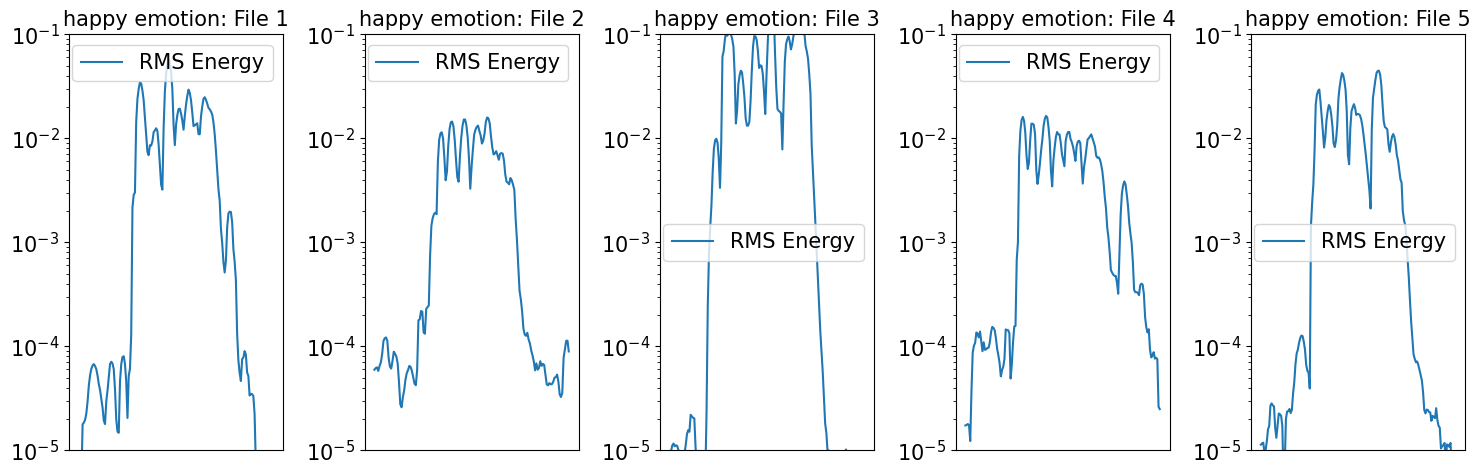

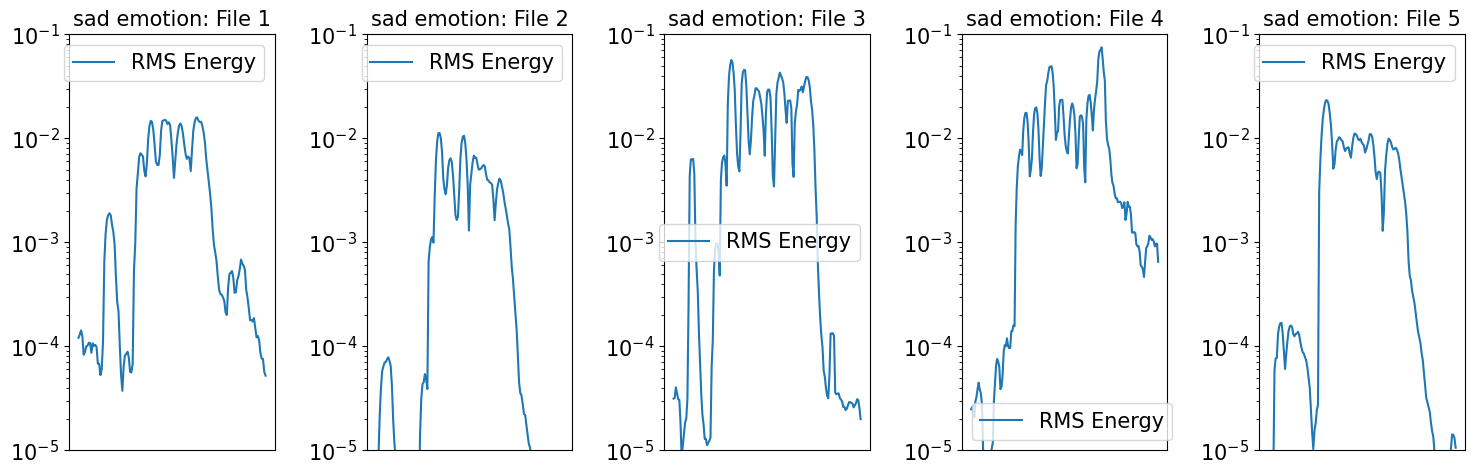

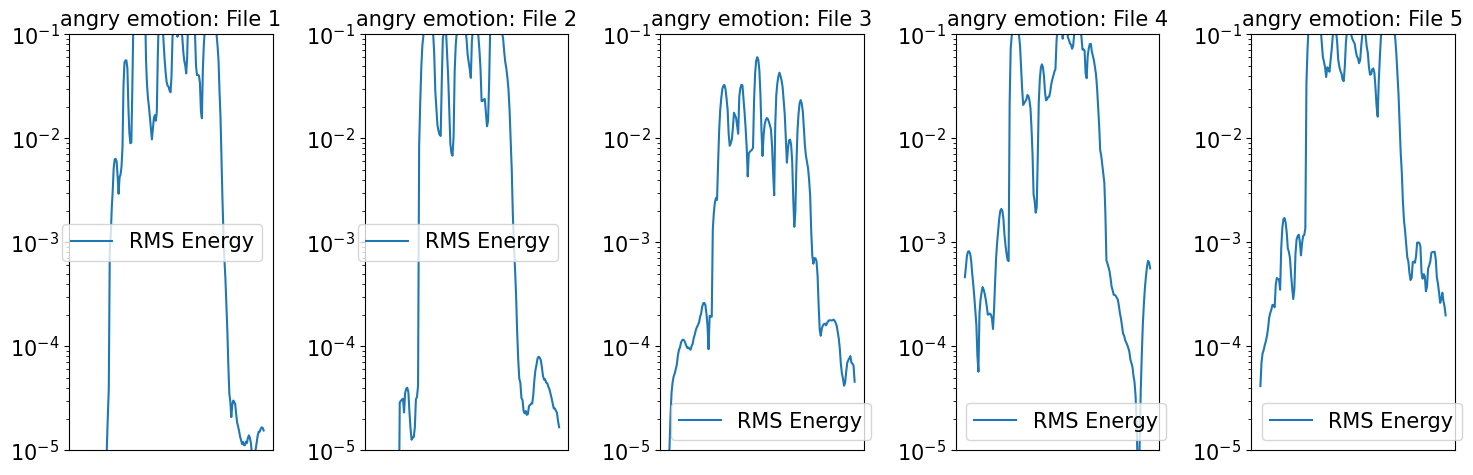

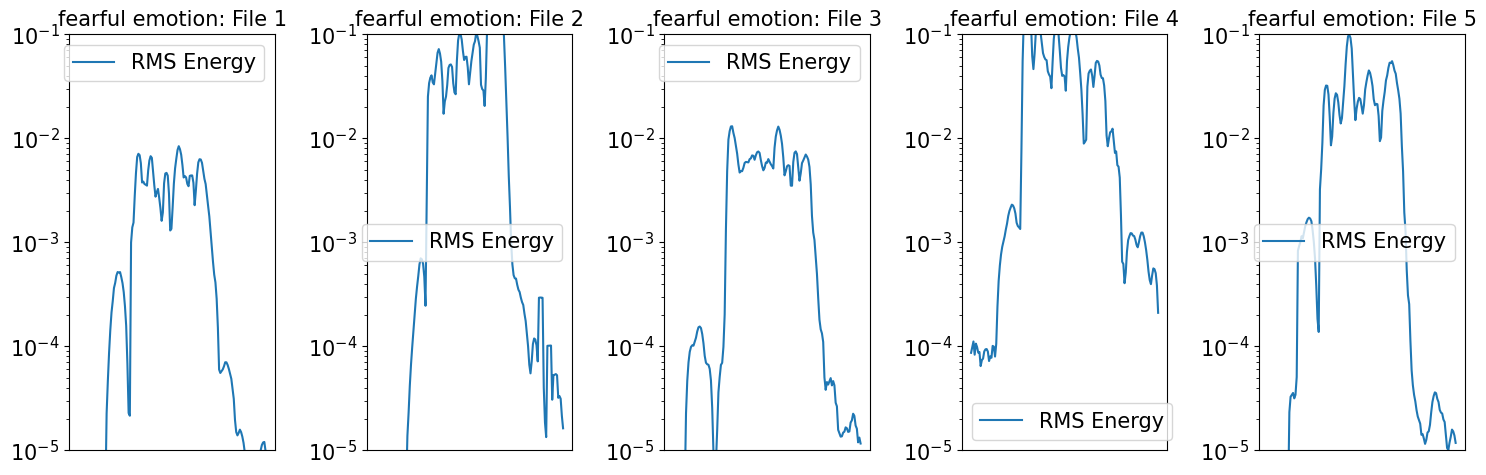

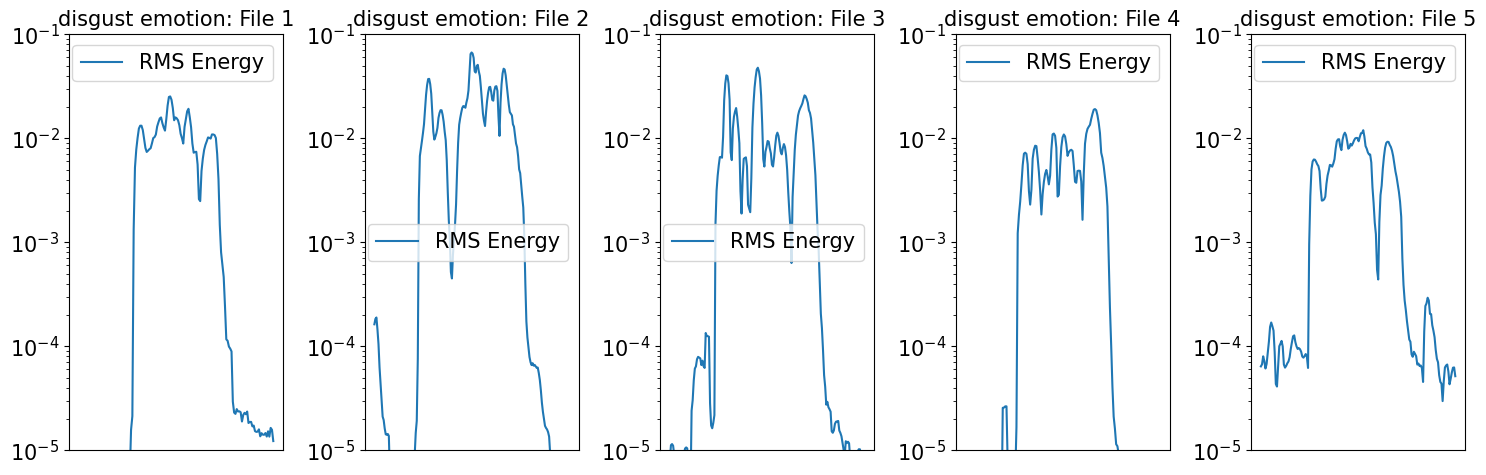

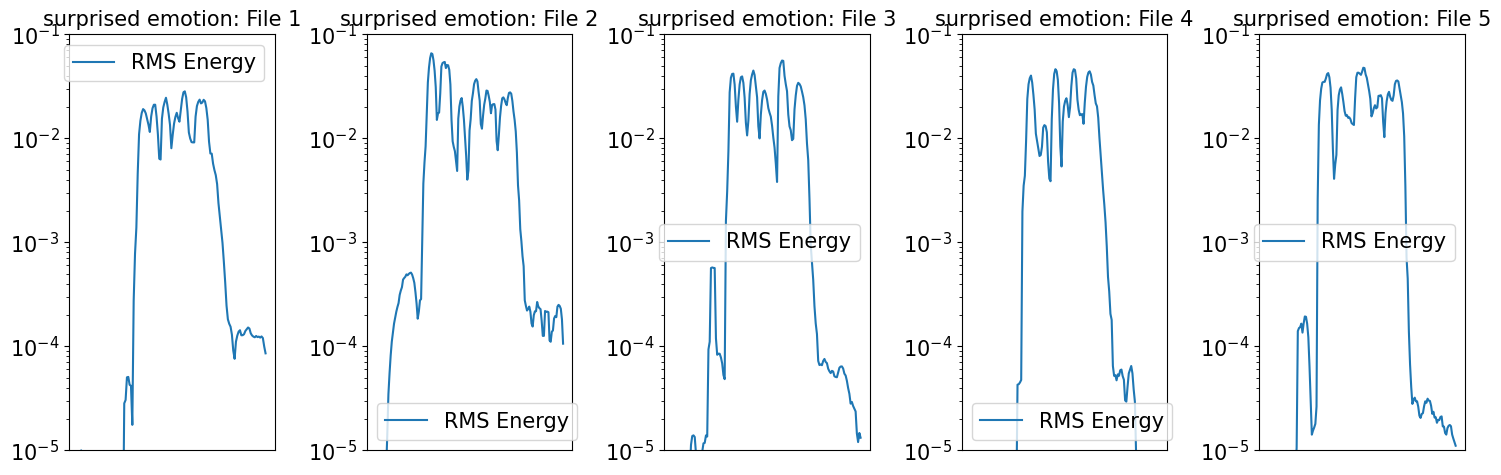

In [29]:
emotions_list = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
num_plots     = 5
for e in emotions_list:
  # Randomly choose row indices where 'Label' column is of the emotion e
  e_indices = tmp_df[tmp_df['Label'] == e].index

  # Randomly choose, for example, 3 indices
  random_indices = np.random.choice(e_indices, size=num_plots, replace=False)

  # Display the plots of audio files at the randomly chosen indices
  random_e_data = df.loc[random_indices]

  fig, ax = plt.subplots(1, num_plots, figsize=(15, 5))
  for iter in range(num_plots):
    filepath  = random_e_data.iloc[iter].File_Path
    data, sampling_rate = librosa.load(filepath)

    rms = librosa.feature.rms(y=data)
    times = librosa.times_like(rms)
    ax[iter].semilogy(times, rms[0], label='RMS Energy')
    ax[iter].set(xticks=[])
    ax[iter].legend()
    ax[iter].set(title='{} emotion: File {}'.format(e, iter+1))
    ax[iter].set(ylim=[1e-5,1e-1])
  # Adjust layout for better spacing
  plt.tight_layout()
  plt.show()

**Inference**: From a quick look through the above plots, it seems like the RMS energy is higher for 'angry' emotion in most cases as compared to other emotions.